In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statistics
from statsmodels.tsa.stattools import adfuller
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn.metrics import root_mean_squared_error
import datetime
import catboost
from catboost import CatBoostRegressor, Pool
from colorama import Fore, Style
from pmdarima import auto_arima
from sklearn.inspection import PartialDependenceDisplay

## Overview

The solution below achieved #1 on the public leaderboard and #2 on the private one for the Adbot Ad Engagement Forecasting Challenge.

The original data is grouped by date and ID and then separated into three groups: (i) active IDs, (ii) inactive IDs from 2023, and (iii) inactive IDs from 2024.

Each group receives a different forecast function that effectively creates a test DataFrame for each of them.
- For group (i), all the IDs are classified as "stationary" or "non-stationary". For stationary IDs, SARIMA is used; otherwise, a moving average is used.
- For groups (ii) and (iii), IDs do not receive classification. Instead, the descriptive ads features are forecasted using a moving average, and the impressions and cost use a decreasing rate. This choice was made because it was observed in the historical data that IDs that became inactive showed a decrease in values for impressions, cost, and consequently, clicks.

After the forecast stage, all the groups are concatenated. The final data transformation updates the last recorded dates for the "gap IDs" clients. This group refers to the IDs that have a gap between their last recorded historical data and the dates requested in the submission file. Since it was observed that once a client became active after a period of inactivity, their metrics continued as if the inactivity never happened, I decided to update the dates to be closer to the submission dates to mimic the historical pattern.

With our final DataFrame in hand, some feature engineering is done, and then the DataFrame is separated into train and test sets. A CatBoost regressor is trained on the entire dataset and then used to make the predictions.

In [2]:
df = pd.read_csv('Train.csv')
submission = pd.read_csv('SampleSubmission.csv')

# we drop records where clicks is NaN
df = df.dropna(subset=['clicks'])
df.reset_index(drop=True, inplace=True)

# My interpretation is that each row represents a different ad.
# This feature will later represent the number (n) of ads in a given day for a given ID.
df['n_ads'] = 1

# Retain only the relevant features
df = df[['ID', 'date','ad_type','impressions', 'clicks', 'ad_description_len', 'headline1_len', 'headline2_len',
         'impression_share', 'cost', 'n_ads']]

df = df.sort_values(by=['ID', 'date']).reset_index(drop=True)

df.head(2)

,ID,date,ad_type,impressions,clicks,ad_description_len,headline1_len,headline2_len,impression_share,cost,n_ads
0,ID_5da86e71bf5dee4cf5047046,2020-01-01,EXPANDED_TEXT_AD,142.0,15.0,11.0,2.0,5.0,16.279669,3393.0,1
1,ID_5da86e71bf5dee4cf5047046,2020-01-01,EXPANDED_TEXT_AD,89.0,8.0,13.0,2.0,2.0,16.279669,1817.0,1


In [3]:
# The objective is to predict the sum of clicks an ID will get in the future, so we group the data by date and ID.
grouped_df = df.groupby(['date', 'ID']).agg({
    'impressions': ['sum'],
    'clicks': ['sum'],
    'ad_description_len': ['sum'],
    'headline1_len': ['sum'],
    'headline2_len': ['sum'],
    'impression_share': ['sum'],
    'cost': ['sum'],
    'n_ads': ['sum'],
    'ad_type': ['nunique']
}).reset_index()

# In case we want to test other methods of aggregation
grouped_df.columns = ['_'.join(col).strip() if col[1] else col[0] for col in grouped_df.columns.values]

# Keep our target with the original name to facilitate later tasks
grouped_df.rename(columns={'clicks_sum': 'clicks'}, inplace=True)

grouped_df['date'] = pd.to_datetime(grouped_df['date'])

**Note**: We could have grouped the data with df.groupby(['date', 'ID', 'ad_type']), which would provide us with more data to work with. Although models generally benefit from having more data for training, this increased granularity has drawbacks, such as fewer or inconsistent data for some combinations of ID and ad_type. Therefore, I decided to group by date and ID. To retain the ad_type information, which is important, we are grouping by the unique ad_types per ID per day, so we know how many different types of ads a given ID was running on a particular day.

## IDs and Dates

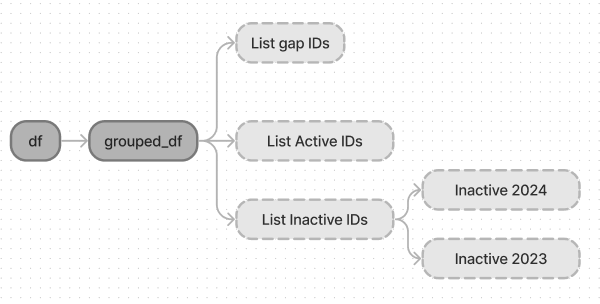

Some IDs have a gap between their last recorded activity and the date requested in the submission file. All these IDs will be stored in a Python list called **list_ids** for later use

In [4]:
# Get the last recorded date for each ID from the original DataFrame
last_dates = df.groupby('ID')['date'].max().reset_index()

# Rename the columns for clarity
last_dates.columns = ['ID', 'last_date']

last_dates['last_date'] = pd.to_datetime(last_dates['last_date'])

# Create a copy of the submission DataFrame to avoid modifying the original
sub = submission.copy()

# Extract the year, month, and day from the ID column in the submission DataFrame
sub[['year', 'month', 'day']] = sub['ID'].str.extract(r'_(\d{4})_(\d{2})_(\d{2})')

# Remove the extracted date part from the ID column
sub['ID'] = sub['ID'].str.replace(r'(_\d{4}_\d{2}_\d{2})$', '', regex=True)

# Combine the extracted year, month, and day into a single date column
sub['date'] = pd.to_datetime(sub[['year', 'month', 'day']])

# Drop duplicate IDs, keeping the first occurrence, to get unique IDs with their respective early dates
unique_df = sub.drop_duplicates(subset='ID', keep='first').copy()

unique_df['date'] = pd.to_datetime(unique_df['date'])

# Merge the unique_df with last_dates to get the last recorded date for each ID
merge_lastdates_unique = unique_df.merge(last_dates, on='ID')

# Calculate the difference in days between the submission date and the last recorded date
merge_lastdates_unique['date_diff'] = (merge_lastdates_unique['date'] - merge_lastdates_unique['last_date']).dt.days

# Get the IDs where the date difference is greater than 8 days
list_ids = merge_lastdates_unique[merge_lastdates_unique['date_diff'] > 8]

list_ids.head(2)

,ID,clicks,year,month,day,date,last_date,date_diff
26,ID_608a6897d96a507cd36c935d,0,2024,02,21,2024-02-21,2023-12-21,62
43,ID_618a50e0500d9413097ccd75,0,2024,02,21,2024-02-21,2024-02-06,15


Analyzing the submission DataFrame gives us the insight that there are many common dates among the IDs. The date 2024-02-21 seems to be the cutoff line between active and inactive IDs.

In [5]:
# Find the earliest date for each ID in the submission DataFrame
sub_min_dates = sub.loc[sub.groupby('ID')['date'].idxmin()]

# Count the occurrences of each date
date_counts = sub_min_dates['date'].value_counts()

# Define the reference date for comparison
reference_date = pd.to_datetime('2024-02-21')

# Check if there are any dates later than the reference date
any_later_date = (date_counts.index > reference_date).any()
any_later_date

False

Let's differentiate the active IDs from the inactive ones.

In [6]:
#Active IDs
ids_with_2024_02_21 = sub_min_dates[sub_min_dates['date'] == reference_date]['ID'].unique().tolist()

#Inactive IDs
ids_with_other_dates = sub_min_dates[sub_min_dates['date'] != reference_date]['ID'].unique().tolist()

print(len(ids_with_2024_02_21))
print(len(ids_with_other_dates))

96
89


In [7]:
# Let's divide the inactive IDs into two groups: those that went inactive in 2023 or earlier, and those that went inactive in 2024.
other_dates_df = sub_min_dates[sub_min_dates['ID'].isin(ids_with_other_dates)]

date_threshold = pd.to_datetime('2024-01-01')
ids_with_2024 = other_dates_df[other_dates_df['date'] >= date_threshold]['ID'].unique().tolist()
ids_with_2023 = other_dates_df[other_dates_df['date'] < date_threshold]['ID'].unique().tolist()

print(len(ids_with_2024))
print(len(ids_with_2023))

33
56


In [8]:
# Finally, create separate DataFrames for each group

# Active group
grouped_df_2024_02_21 = grouped_df[grouped_df['ID'].isin(ids_with_2024_02_21)]

# Inactive in 2024
grouped_df_ids_with_2024 = grouped_df[grouped_df['ID'].isin(ids_with_2024)]

# Inactive in 2023
grouped_df_ids_with_2023 = grouped_df[grouped_df['ID'].isin(ids_with_2023)]

print(grouped_df_2024_02_21.shape)
print(grouped_df_ids_with_2024.shape)
print(grouped_df_ids_with_2023.shape)

(45462, 11)
(8028, 11)
(14078, 11)


## Forecast Based on Groups

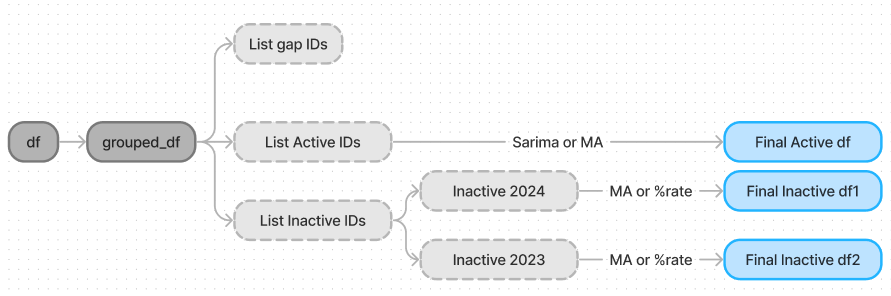

**Group 1** consists of the active IDs. Each ID has the features clicks, impressions, impression_share, and cost classified as stationary, non-stationary, not enough data, or constant. While there are four types of classification, what really matters here is whether a given time series is stationary or not.

In [ ]:
%%time

def classify_series(x):
    if len(x) < 10:
        return "not enough data"
    if x.nunique() == 1:
        return "Constant" 
    result = adfuller(x.dropna())
    p_value = result[1]
    if p_value < 0.05:
        return "stationary"
    else:
        return "Non stationary"

grouped_df_2024_02_21 = grouped_df_2024_02_21.sort_values(by=['ID', 'date']).reset_index(drop=True)
grouped_df_2024_02_21['classification_clicks'] = grouped_df_2024_02_21.groupby(['ID'])['clicks'].transform(classify_series)
grouped_df_2024_02_21['classification_impressions_sum'] = grouped_df_2024_02_21.groupby(['ID'])['impressions_sum'].transform(classify_series)
grouped_df_2024_02_21['classification_impression_share_sum'] = grouped_df_2024_02_21.groupby(['ID'])['impression_share_sum'].transform(classify_series)
grouped_df_2024_02_21['classification_cost_sum'] = grouped_df_2024_02_21.groupby(['ID'])['cost_sum'].transform(classify_series)

print(grouped_df_2024_02_21.shape)

In [ ]:
grouped_df_2024_02_21.head(2)

Ad descriptive columns will be forecasted using a moving average. Features that received classification will be checked to determine whether they are stationary or not. If they are stationary, then SARIMA is used; otherwise, a moving average is used.

The forecast functions dynamically so that each new row is used in the calculation of the next row, and so on.

The feature 'is_forecast' is created to help us identify the rows that were created in the process.

In [ ]:
%%time

# Columns to be forecasted that require classification check
forecast_columns_with_classification = ['impressions_sum', 'clicks', 'impression_share_sum', 'cost_sum']

# Columns to be forecasted without requiring classification check
forecast_columns_without_classification = ['ad_description_len_sum', 'headline1_len_sum', 'headline2_len_sum', 'n_ads_sum', 'ad_type_nunique']

def forecast_arima(series, forecast_horizon):
    """
    Forecasts the given time series using ARIMA model.
    
    Parameters:
    series (pd.Series): The time series data to forecast.
    forecast_horizon (int): The number of periods to forecast into the future.
    
    Returns:
    np.ndarray: Forecasted values for the specified horizon.
    """
    
    # Ensure the series index is in datetime format
    series.index = pd.to_datetime(series.index)

    # Ensure the series has a daily frequency
    if not series.index.freq:
        series = series.asfreq('D')

    # Fill missing values
    series.ffill(inplace=True)
    series.bfill(inplace=True)

    # Fit ARIMA model and forecast
    model = auto_arima(series, seasonal=True, stepwise=True, suppress_warnings=True, error_action="ignore", trace=True, m=7)
    forecast = model.predict(n_periods=forecast_horizon)
    
    return forecast

def dynamic_forecast_moving_average(series, window, forecast_horizon):
    """
    Forecasts the given time series using moving average dynamically.
    
    Parameters:
    series (pd.Series): The time series data to forecast.
    window (int): The window size for the moving average.
    forecast_horizon (int): The number of periods to forecast into the future.
    
    Returns:
    list: Forecasted values for the specified horizon.
    """
    values = list(series.dropna())

     # Handle empty series
    if not values:
        return [np.nan] * forecast_horizon

    # Generate forecasts dynamically
    for _ in range(forecast_horizon):
        moving_avg = np.mean(values[-window:]) if len(values) >= window else np.mean(values)
        values.append(moving_avg)
        
    return values[-forecast_horizon:]

def add_dynamic_forecasts(group, forecast_horizon, window):
    """
    Adds dynamic forecasts to the group DataFrame.
    
    Parameters:
    group (pd.DataFrame): The data group to forecast.
    forecast_horizon (int): The number of periods to forecast into the future.
    window (int): The window size for the moving average.
    
    Returns:
    pd.DataFrame: DataFrame containing the original data and forecasted values.
    """
    
    group = group.set_index('date')
    group.index = pd.to_datetime(group.index)
    group = group.asfreq('D', method='ffill')

    last_date = group.index.max()
    forecast_dates = pd.date_range(start=last_date, periods=forecast_horizon + 1, freq='D')[1:]
    forecast_data = {}

    # Forecast columns with classification
    for col in forecast_columns_with_classification:
        classification_col = f"classification_{col}"
        if group[classification_col].iloc[0] == "stationary":
            forecast_data[col] = forecast_arima(group[col].dropna(), forecast_horizon)
        else:
            forecast_data[col] = dynamic_forecast_moving_average(group[col], window, forecast_horizon)

    # Forecast columns without classification
    for col in forecast_columns_without_classification:
        forecast_data[col] = dynamic_forecast_moving_average(group[col], window, forecast_horizon)

    forecast_df = pd.DataFrame(forecast_data, index=forecast_dates)
    forecast_df['ID'] = group['ID'].iloc[0]
    forecast_df['is_forecast'] = True

    group = group.reset_index()
    forecast_df = forecast_df.reset_index().rename(columns={'index': 'date'})

    return forecast_df

# Prepare to forecast data for all IDs in this group
all_data = []
window_size = 13
forecast_horizon = 16

# Loop through each group by ID
for name, group in grouped_df_2024_02_21.groupby(['ID']):
    forecast_df = add_dynamic_forecasts(group, forecast_horizon, window_size)
    all_data.append(pd.concat([group.reset_index(drop=True), forecast_df]))

# Combine all forecasted data and original data
grouped_df_2024_02_21 = pd.concat(all_data).sort_values(by=['ID', 'date'])
grouped_df_2024_02_21['is_forecast'] = grouped_df_2024_02_21['is_forecast'].fillna(False)
print(grouped_df_2024_02_21.shape)

#Wall time: 1h 49min 49s

In [ ]:
# Drop classification columns
grouped_df_2024_02_21.drop(columns=[ 'classification_clicks', 'classification_impressions_sum', 'classification_impression_share_sum',
       'classification_cost_sum'], inplace=True)

In [ ]:
# grouped_df_2024_02_21.to_csv('gg_2024_02_21.csv', index=False)

For **Groups 2 and 3**, the descriptive ad features use a moving average, and the other features use a decreasing rate. This decision was made after analyzing the historical pattern of the clients. When a client is near the end of activity, their metrics start to decrease.

We apply different decreasing rates for Groups 2 and 3 because the inactive group of 2024 shows higher metrics at the beginning of the year, so consequently, they will also take a longer time to decrease.

The functions below for groups 2 and 3 are very similar to the one used for Group 1.

In [9]:
#Group 2 -> Inactives from 2023

forecast_columns_moving_average = ['ad_description_len_sum', 'headline1_len_sum', 'headline2_len_sum', 'n_ads_sum', 'ad_type_nunique']
forecast_columns_decreasing = ['impressions_sum', 'clicks', 'impression_share_sum', 'cost_sum']

def dynamic_forecast_moving_average(series, window, forecast_horizon):
    values = list(series.dropna())
    if not values:
        return [np.nan] * forecast_horizon
    for _ in range(forecast_horizon):
        moving_avg = np.mean(values[-window:]) if len(values) >= window else np.mean(values)
        values.append(moving_avg)
    return values[-forecast_horizon:]

def dynamic_forecast_decreasing(last_value, forecast_horizon):
    values = []
    current_value = last_value

    for day in range(forecast_horizon):
        if day < 3:
            decrement = current_value * 0.5
        else:
            decrement = current_value * 0.15
        
        current_value -= decrement
        values.append(current_value)
    
    return values

def add_dynamic_forecasts(group, forecast_horizon, window):
    group = group.set_index('date')
    group.index = pd.to_datetime(group.index)
    group = group.asfreq('D', method='ffill')

    last_date = group.index.max()
    forecast_dates = pd.date_range(start=last_date, periods=forecast_horizon + 1, freq='D')[1:]
    forecast_data = {}

    for col in forecast_columns_moving_average:
        forecast_data[col] = dynamic_forecast_moving_average(group[col], window, forecast_horizon)

    for col in forecast_columns_decreasing:
        last_value = group[col].iloc[-1]
        forecast_data[col] = dynamic_forecast_decreasing(last_value, forecast_horizon)

    forecast_df = pd.DataFrame(forecast_data, index=forecast_dates)
    forecast_df['ID'] = group['ID'].iloc[0]
    forecast_df['is_forecast'] = True

    group = group.reset_index()
    forecast_df = forecast_df.reset_index().rename(columns={'index': 'date'})

    return forecast_df

all_data = []
window_size = 13
forecast_horizon = 15

for name, group in grouped_df_ids_with_2023.groupby(['ID']):
    forecast_df = add_dynamic_forecasts(group, forecast_horizon, window_size)
    all_data.append(pd.concat([group.reset_index(drop=True), forecast_df]))

grouped_df_ids_with_2023 = pd.concat(all_data).sort_values(by=['ID', 'date'])
grouped_df_ids_with_2023['is_forecast'] = grouped_df_ids_with_2023['is_forecast'].fillna(False)
print(grouped_df_ids_with_2023.shape)

(14918, 12)


C:\Users\yan.teixeira\AppData\Local\Temp\ipykernel_21304\3879434163.py:64: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  grouped_df_ids_with_2023['is_forecast'] = grouped_df_ids_with_2023['is_forecast'].fillna(False)


In [10]:
#Group 3 -> Inactives from 2024

forecast_columns_moving_average = ['ad_description_len_sum', 'headline1_len_sum', 'headline2_len_sum', 'n_ads_sum', 'ad_type_nunique']
forecast_columns_decreasing = ['impressions_sum', 'clicks', 'impression_share_sum', 'cost_sum']

def dynamic_forecast_moving_average(series, window, forecast_horizon):
    values = list(series.dropna())
    if not values:
        return [np.nan] * forecast_horizon
    for _ in range(forecast_horizon):
        moving_avg = np.mean(values[-window:]) if len(values) >= window else np.mean(values)
        values.append(moving_avg)
    return values[-forecast_horizon:]

def dynamic_forecast_decreasing(last_value, forecast_horizon):
    values = []
    current_value = last_value

    for day in range(forecast_horizon):
        if day < 8:
            decrement = current_value * 0.01
        else:
            decrement = current_value * 0.1
        
        current_value -= decrement
        values.append(current_value)
    
    return values

def add_dynamic_forecasts(group, forecast_horizon, window):
    group = group.set_index('date')
    group.index = pd.to_datetime(group.index)
    group = group.asfreq('D', method='ffill')

    last_date = group.index.max()
    forecast_dates = pd.date_range(start=last_date, periods=forecast_horizon + 1, freq='D')[1:]
    forecast_data = {}

    for col in forecast_columns_moving_average:
        forecast_data[col] = dynamic_forecast_moving_average(group[col], window, forecast_horizon)

    for col in forecast_columns_decreasing:
        last_value = group[col].iloc[-1]
        forecast_data[col] = dynamic_forecast_decreasing(last_value, forecast_horizon)

    forecast_df = pd.DataFrame(forecast_data, index=forecast_dates)
    forecast_df['ID'] = group['ID'].iloc[0]
    forecast_df['is_forecast'] = True

    group = group.reset_index()
    forecast_df = forecast_df.reset_index().rename(columns={'index': 'date'})

    return forecast_df

all_data = []
window_size = 13
forecast_horizon = 15

for name, group in grouped_df_ids_with_2024.groupby(['ID']):
    forecast_df = add_dynamic_forecasts(group, forecast_horizon, window_size)
    all_data.append(pd.concat([group.reset_index(drop=True), forecast_df]))

grouped_df_ids_with_2024 = pd.concat(all_data).sort_values(by=['ID', 'date'])
grouped_df_ids_with_2024['is_forecast'] = grouped_df_ids_with_2024['is_forecast'].fillna(False)
print(grouped_df_ids_with_2024.shape)

(8523, 12)


C:\Users\yan.teixeira\AppData\Local\Temp\ipykernel_21304\2815449835.py:64: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  grouped_df_ids_with_2024['is_forecast'] = grouped_df_ids_with_2024['is_forecast'].fillna(False)


In [11]:
#concat groups 2 and 3 in the same dataframe
grouped_df_other_dates = pd.concat([grouped_df_ids_with_2023, grouped_df_ids_with_2024])
grouped_df_other_dates.reset_index(drop=True, inplace=True)

For Groups 2 and 3, we add to the to the future training data the forecasted data that is before the first date asked for the submission file.

In [12]:
id_to_min_date = sub_min_dates.set_index('ID')['date'].to_dict()

def set_is_forecast(row):
    """
    Determine if a row should be marked as forecasted or not based on the minimum date for its ID.
    
    Parameters:
    row (pd.Series): A row from the DataFrame being processed.
    
    Returns:
    bool: True if the row's date is on or after the minimum date for its ID; False otherwise.
    """

    # Get the minimum date for the given ID from the dictionary
    min_date = id_to_min_date.get(row['ID'], None)

    # If there is a minimum date and the row's date is earlier than the minimum date, return False
    if min_date and row['date'] < min_date:
        return False
    return True

grouped_df_other_dates['is_forecast'] = grouped_df_other_dates.apply(set_is_forecast, axis=1)

## Final DataFrame

In [13]:
# to save time we can load the files from here
# concatenated_df = pd.read_csv('concatenated_df.csv')
grouped_df_2024_02_21 = pd.read_csv('gg_2024_02_21.csv')

In [14]:
# Finally we form the final dataframe by concatenat the dataframes
concatenated_df = pd.concat([grouped_df_other_dates, grouped_df_2024_02_21])
concatenated_df.reset_index(drop=True, inplace=True)
# concatenated_df.to_csv('concatenated_df.csv', index=False)

print(concatenated_df.shape)

(70439, 12)


In [15]:
concatenated_df = concatenated_df.sort_values(by=['ID', 'date']).reset_index(drop=True)
concatenated_df['date'] = pd.to_datetime(concatenated_df['date'])

# take the mean of each feature
concatenated_df['impressions_mean'] = concatenated_df['impressions_sum']/concatenated_df['n_ads_sum']
concatenated_df['ad_description_len_mean'] = concatenated_df['ad_description_len_sum']/concatenated_df['n_ads_sum']
concatenated_df['headline1_len_mean'] = concatenated_df['headline1_len_sum']/concatenated_df['n_ads_sum']
concatenated_df['headline2_len_mean'] = concatenated_df['headline2_len_sum']/concatenated_df['n_ads_sum']
concatenated_df['impression_share_mean'] = concatenated_df['impression_share_sum']/concatenated_df['n_ads_sum']
concatenated_df['cost_mean'] = concatenated_df['cost_sum']/concatenated_df['n_ads_sum']

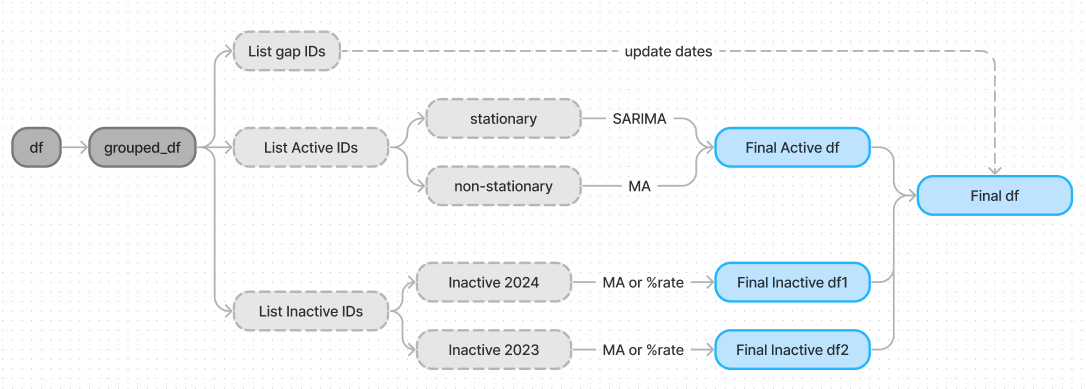

The final data transformation updates the last recorded dates for the "gap IDs" clients. This group refers to the IDs that have a gap between their last recorded historical data and the dates requested in the submission file. Since it was observed that once a client became active after a period of inactivity, their metrics continued as if the inactivity never happened, I decided to update the dates to be closer to the submission dates to mimic the historical pattern.

In [16]:
# Merge our final DataFrame with the list_ids we created at the very beginning of this notebook
merged_df = pd.merge(concatenated_df, list_ids[['ID', 'date']], on='ID', how='left', suffixes=('', '_new_start'))

# Function to update dates
def update_dates(row):
    if row['is_forecast'] and pd.notna(row['date_new_start']):
        # Calculate the offset from the first forecast date
        offset = (row['date'] - row['first_forecast_date']).days
        # Apply this offset to the new start date
        return pd.to_datetime(row['date_new_start']) + pd.DateOffset(days=offset)
    else:
        return row['date']

# Find the first forecast date for each ID
first_forecast_dates = concatenated_df[concatenated_df['is_forecast']].groupby('ID')['date'].min().reset_index()
first_forecast_dates.rename(columns={'date': 'first_forecast_date'}, inplace=True)

# Merge this back to the main DataFrame
merged_df = pd.merge(merged_df, first_forecast_dates, on='ID', how='left')

# Apply the function to update the dates
merged_df['date'] = merged_df.apply(update_dates, axis=1)

# Drop the temporary columns
merged_df.drop(columns=['date_new_start', 'first_forecast_date'], inplace=True)

In [17]:
merged_df.shape

(70439, 18)

In [18]:
# Add time series features

merged_df['date'] = pd.to_datetime(merged_df['date'])

merged_df['day_of_week'] = merged_df['date'].dt.dayofweek
merged_df['day'] = merged_df['date'].dt.day
merged_df['month'] = merged_df['date'].dt.month
merged_df['year'] = merged_df['date'].dt.year
merged_df['week_of_year'] = merged_df['date'].dt.isocalendar().week

merged_df['is_weekend'] = merged_df['date'].dt.weekday.isin([5, 6]).astype(int)
merged_df['is_month_start'] = merged_df['date'].dt.is_month_start.astype(int)
merged_df['is_month_end'] = merged_df['date'].dt.is_month_end.astype(int)

# Add interaction features
merged_df['ad_lenght_sum'] = merged_df['ad_description_len_sum'] + merged_df['headline1_len_sum'] + merged_df['headline2_len_sum']
merged_df['cost_eff_sum'] = merged_df['cost_sum']/merged_df['impressions_sum']

The interaction between cost, impressions, and clicks is complex, so we add another feature to help the model. The new feature will act as a kind of trend, indicating whether the cost and impressions values are greater than their lags.

In order to create the lag features, we will take care to consider that we have different IDs with different time series, and that these time series might have gaps.

In [19]:
%%time

merged_df.sort_values(by='date', inplace=True)

columns_to_lag = ['impressions_sum', 'cost_sum', 'impressions_mean', 'cost_mean']

lags = [1]

# Create a helper column to detect gaps
merged_df['prev_date'] = merged_df.groupby('ID')['date'].shift(1)
merged_df['date_diff'] = (merged_df['date'] - merged_df['prev_date']).dt.days

for lag in lags:
    for column in columns_to_lag:
        # Calculate the lagged values
        merged_df[f'{column}_lag_{lag}'] = merged_df.groupby('ID')[column].shift(lag)
        
        # If there is a gap, set the lagged value to NaN
        merged_df.loc[merged_df['date_diff'] != 1, f'{column}_lag_{lag}'] = pd.NA

# Drop the helper columns as they are no longer needed
merged_df.drop(columns=['prev_date', 'date_diff'], inplace=True)


def determine_trend_mean(row):
    if pd.isna(row['impressions_sum_lag_1']) or pd.isna(row['cost_sum_lag_1']):
        return 'diverge'     
    if (row['impressions_mean'] > row['impressions_mean_lag_1']) and (row['cost_mean'] > row['cost_mean_lag_1']):
        return 'both_up'
    elif (row['impressions_mean'] < row['impressions_mean_lag_1']) and (row['cost_mean'] < row['cost_mean_lag_1']):
        return 'both_down'
    elif (row['impressions_mean'] < row['impressions_mean_lag_1']) and (row['cost_mean'] > row['cost_mean_lag_1']):
        return 'cost_up'
    elif (row['impressions_mean'] > row['impressions_mean_lag_1']) and (row['cost_mean'] < row['cost_mean_lag_1']):
        return 'imp_up'
    else:
        return 'diverge'

merged_df['trend_mean'] = merged_df.apply(determine_trend_mean, axis=1)

CPU times: total: 1.22 s
Wall time: 1.43 s


In [20]:
# With all set, now we create the train and test data
train = merged_df[merged_df['is_forecast'] == False]
test = merged_df[merged_df['is_forecast'] == True]

## Preparation

In [21]:
# Let's ensure that the test data only includes the dates requested in the submission file.
sub = submission.copy()
sub[['year', 'month', 'day']] = sub['ID'].str.extract(r'_(\d{4})_(\d{2})_(\d{2})')
sub['ID'] = sub['ID'].str.replace(r'(_\d{4}_\d{2}_\d{2})$', '', regex=True)
sub['date'] = pd.to_datetime(sub[['year', 'month', 'day']])

filtered_test = pd.merge(test, sub[['ID', 'date']], on=['ID', 'date'])

# Helper dataframe
tt2 = filtered_test.copy()

In [23]:
train = train.sort_values(by=['date']).reset_index(drop=True)

# Drop columns that we will not use
train.drop(columns=['is_forecast', 'date', 'impressions_sum_lag_1', 'cost_sum_lag_1', 'impressions_mean_lag_1',
       'cost_mean_lag_1', 'ID'], inplace=True)
filtered_test.drop(columns=['is_forecast', 'date', 'clicks', 'impressions_sum_lag_1', 'cost_sum_lag_1', 'impressions_mean_lag_1',
       'cost_mean_lag_1', 'ID'], inplace=True)

## Model

In [24]:
# Flag to determine if test predictions should be computed
COMPUTE_TEST_PRED = True

# Dictionaries to store out-of-fold predictions and test predictions
oof, test_pred = {}, {}

# CV strategy
kf = KFold(n_splits=3, shuffle=True, random_state=1)

# Flag to determine if only a single fold should be used
SINGLE_FOLD = False

def cross_validate(model, label, features, n_repeats=1):
    
    """
    Perform cross-validation for a given model, and optionally compute test predictions.
    
    Parameters:
    model (sklearn estimator): The machine learning model to be used.
    label (str): A label for identifying the model in the outputs.
    features (list): List of feature names to be used for training.
    n_repeats (int): Number of times to repeat the training for averaging predictions (default is 1).
    
    Returns:
    float: The mean score (RMSE) across all folds.
    """
    
    start_time = datetime.datetime.now()
    scores = []
    oof_preds = np.full_like(train.clicks, np.nan, dtype=float)

    for fold, (idx_tr, idx_va) in enumerate(kf.split(train)):
        # Split the training data into training and validation sets based on the current fold
        X_tr = train.iloc[idx_tr][features]
        X_va = train.iloc[idx_va][features]
        y_tr = train.iloc[idx_tr].clicks
        y_va = train.iloc[idx_va].clicks
        
        y_pred = np.zeros_like(y_va, dtype=float)

        # Train the model n_repeats times and average the predictions
        for i in range(n_repeats):
            m = clone(model) # Clone the model to ensure fresh state
            if n_repeats > 1:
                mm = m
                if isinstance(mm, Pipeline):
                    mm = mm[-1] # Get the final estimator in the pipeline
                mm.set_params(random_state=i) # Set random state for reproducibility
            m.fit(X_tr, y_tr) # Fit the model on the training data
            y_pred += m.predict(X_va) # Predict on the validation data
        y_pred /= n_repeats # Average the predictions
        
        score = root_mean_squared_error(y_va, y_pred)
        print(f"# Fold {fold}: RMSE={score:.5f}")
        scores.append(score)
        oof_preds[idx_va] = y_pred
        if SINGLE_FOLD:
            break # Exit the loop if only a single fold is to be used

    mean_score = np.mean(scores)

    elapsed_time = datetime.datetime.now() - start_time
    print(f"{Fore.GREEN}# Overall: {mean_score:.5f} {label}"
          f"{' single fold' if SINGLE_FOLD else ''}"
          f"   {int(np.round(elapsed_time.total_seconds() / 60))} min{Style.RESET_ALL}")
    oof[label] = oof_preds

    # Calculate and plot feature importances
    feature_importances = m.get_feature_importance()
    feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.gca().invert_yaxis()
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'Feature Importances for {label}')
    plt.show()

    # Store the top features
    top_5_features = feature_importance_df.head(5)['Feature'].tolist()
    print(f"Top 5 Features: {top_5_features}")
    
    if COMPUTE_TEST_PRED:
        # Retrain the model n_repeats times on the entire training data and average the test predictions
        y_pred = np.zeros(len(filtered_test), dtype=float)
        X_tr = train[features]
        y_tr = train.clicks        
        
        for i in range(n_repeats):
            m = clone(model)
            if n_repeats > 1:
                mm = m
                if isinstance(mm, Pipeline):
                    mm = mm[-1]
                mm.set_params(random_state=i)
            m.fit(X_tr, y_tr)
            y_pred += m.predict(filtered_test[features])
        y_pred /= n_repeats
        test_pred[label] = y_pred
    
    return mean_score, top_5_features, X_tr, y_tr, m

# Fold 0: RMSE=29.39201
# Fold 1: RMSE=17.71555
# Fold 2: RMSE=14.83840
# Overall: 20.64866 CatBoost   1 min


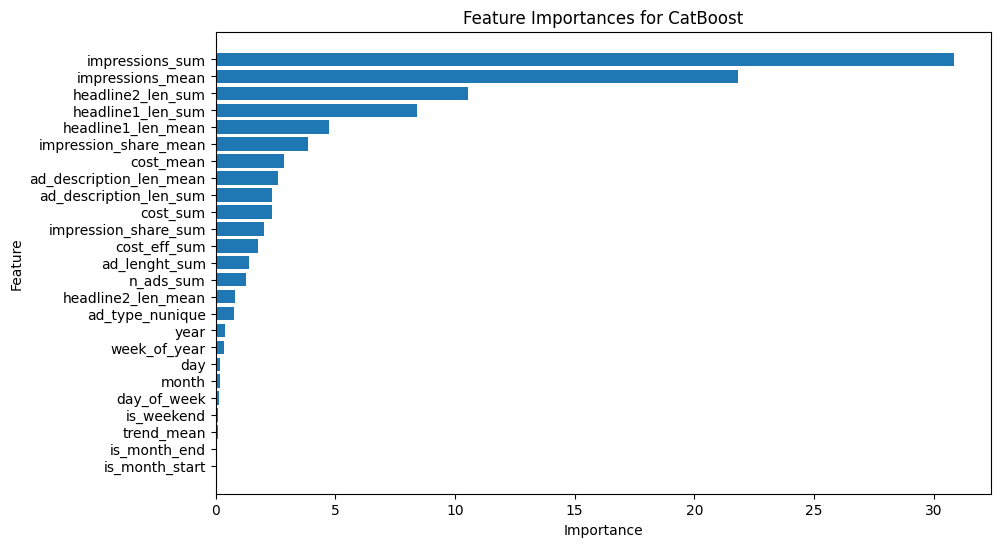

Top 5 Features: ['impressions_sum', 'impressions_mean', 'headline2_len_sum', 'headline1_len_sum', 'headline1_len_mean']


In [26]:
initial_features = list(filtered_test.columns)
cat_features = ['trend_mean']

model = catboost.CatBoostRegressor(verbose=False, iterations=500, cat_features=cat_features)
mean_score, top_5_features, X_tr, y_tr, m = cross_validate(model, 'CatBoost', features=initial_features)

# Fold 0: RMSE=14.69955
# Fold 1: RMSE=16.89513
# Fold 2: RMSE=30.97323
# Overall: 20.85597 CatBoost   1 min

## Analysis

Partial Dependence Plots show the marginal effect of a feature on the predicted outcome. We ca visualize how changes in a single feature impact the number of clicks while keeping other features constant.

In [ ]:
%%time

def analyze_multiple_features_impact(model, features, train, target, features_to_analyze):
    """
    Analyze the impact of multiple features on the target using Partial Dependence Plot.

    Parameters:
    model (sklearn estimator): The trained machine learning model.
    features (list): List of feature names used for training.
    train (pd.DataFrame): The training dataset.
    target (str): The target variable name.
    features_to_analyze (list): The features for which to analyze the impact.

    """
    
    # Ensure all features to analyze are in the list of features
    for feature in features_to_analyze:
        if feature not in features:
            raise ValueError(f"The feature '{feature}' is not in the list of training features.")

    n_features = len(features_to_analyze)
    n_cols = 2
    n_rows = (n_features + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten()

    for i, feature in enumerate(features_to_analyze):
        PartialDependenceDisplay.from_estimator(model, train[features], [feature], ax=axes[i], grid_resolution=50)
        axes[i].set_title(f'Partial Dependence Plot for {feature}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Partial dependence')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Features to analyze
features_to_analyze = ['impressions_sum', 'impressions_mean', 'headline1_len_sum', 'ad_description_len_sum', 'headline2_len_sum']
analyze_multiple_features_impact(m, initial_features, train, 'clicks', features_to_analyze)

## Report

In [ ]:
%%time

def sensitivity_analysis(model, features, X_tr, y_tr, top_features, step=0.1, num_steps=10):
    """
    Perform sensitivity analysis on the top features.

    Parameters:
    model (CatBoostRegressor): Trained model.
    features (list): List of feature names.
    X_tr (DataFrame): Training data features.
    y_tr (Series): Training data target variable.
    top_features (list): List of top features for sensitivity analysis.
    step (float): The step size for changing feature values (default is 0.1).
    num_steps (int): The number of steps to change the feature value (default is 10).

    Returns:
    DataFrame: Sensitivity analysis results for each feature.
    """
    
    results = []
    
    for feature in top_features:
        feature_vals = np.linspace(
            X_tr[feature].min(), 
            X_tr[feature].max(), 
            num=num_steps
        )
        mean_clicks = []
        
        for val in feature_vals:
            X_temp = X_tr.copy()
            X_temp[feature] = val
            predictions = model.predict(X_temp)
            mean_clicks.append(np.mean(predictions))
        
        results.append({
            'Feature': feature,
            'Values': feature_vals,
            'Mean_Clicks': mean_clicks
        })
        
    return results

# Perform sensitivity analysis
results = sensitivity_analysis(m, initial_features, X_tr, y_tr, top_5_features, step=0.2, num_steps=20)

num_features = len(results)
num_cols = 2
num_rows = (num_features + 1) // num_cols

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 6))

for i, result in enumerate(results):
    row = i // num_cols
    col = i % num_cols
    ax = axs[row, col]
    ax.plot(result['Values'], result['Mean_Clicks'], marker='o')
    ax.set_title(f'Sensitivity Analysis for {result["Feature"]}')
    ax.set_xlabel(f'{result["Feature"]} Value')
    ax.set_ylabel('Predicted Mean Clicks')
    ax.grid(True)

for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout()
plt.show()

## Predictions

In [29]:
# if the value of a prediction is negative, then turns into zero
test_pred['CatBoost'] = np.where(test_pred['CatBoost'] < 0, 0, test_pred['CatBoost'])
filtered_test['clicks'] = test_pred['CatBoost']

# date was dropped, so we get the feature back
filtered_test['date'] = tt2['date']
filtered_test['ID'] = tt2['ID']

In [30]:
preds_data = pd.merge(sub, filtered_test, on=['ID', 'date'], how='left')

click_sums = preds_data.groupby(['ID', 'date'])['clicks_y'].sum().reset_index()
click_sums.rename(columns={'clicks_y': 'sum_clicks'}, inplace=True)
sub = pd.merge(sub, click_sums, on=['ID', 'date'], how='left')
sub['clicks'] = sub['sum_clicks']

# Drop the temporary 'sum_clicks' column
sub.drop(columns='sum_clicks', inplace=True)

# submission file
submission['clicks'] = sub['clicks']
submission.head(5)

,ID,clicks
0,ID_5da86e71bf5dee4cf5047046_2024_01_22,109.343786
1,ID_5da86e71bf5dee4cf5047046_2024_01_29,60.287973
2,ID_5e43c29e6279884e2827d894_2024_02_21,3.014387
3,ID_5e43c29e6279884e2827d894_2024_02_28,5.141059
4,ID_5e4e7b480e374330ee151305_2023_12_04,3.209872


In [31]:
submission.to_csv('submission.csv', index=False)